## Creating CNN Using Scratch And Transfer Learning

In [1]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [2]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'Dataset/Train'
valid_path = 'Dataset/Test'


In [3]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

mobilnet = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False) #include_top=False => we are not taking the 1st and last layer of the model
                                                                                     #because in 1st layer we define our image size and in 2nd we define no of classes



80142336/80134624 [==============================] - 163s 2us/step


In [4]:
# don't train existing weights
for layer in mobilnet.layers:
    layer.trainable = False

In [5]:
  # useful for getting number of output classes
folders = glob('Dataset/Train/*')

In [6]:
folders

['Dataset/Train/Parasite', 'Dataset/Train/Uninfected']

In [7]:
# our layers - you can add more if you want
x = Flatten()(mobilnet.output)

In [8]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=mobilnet.input, outputs=prediction)

In [9]:

# view the structure of the model
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [10]:
from tensorflow.keras.layers import MaxPooling2D

In [38]:
### Create model1 from scratch using CNN
model1=Sequential()
model1.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(224,224,3)))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Conv2D(filters=32,kernel_size=2,padding="same",activation ="relu"))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Flatten())
model1.add(Dense(500,activation="relu"))
model1.add(Dense(2,activation="softmax"))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)            

In [11]:
# tell the model what cost and optimization method to use this is for transfer learning model
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [12]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [13]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('Dataset/Train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 416 images belonging to 2 classes.


In [14]:
training_set

In [15]:
test_set = test_datagen.flow_from_directory('Dataset/Test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 134 images belonging to 2 classes.


In [18]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=2,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)    #train it for more epochs...

Epoch 1/2
13/13 [==============================] - 151s 12s/step - loss: 1.4897 - accuracy: 0.5433 - val_loss: 0.9897 - val_accuracy: 0.4925
Epoch 2/2
13/13 [==============================] - 150s 12s/step - loss: 0.6897 - accuracy: 0.6490 - val_loss: 0.6721 - val_accuracy: 0.7015


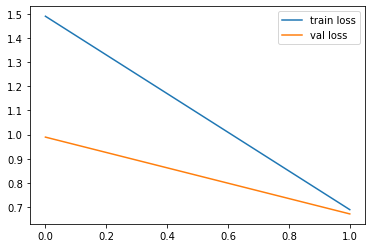

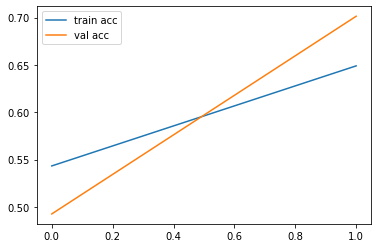

<Figure size 432x288 with 0 Axes>

In [19]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [20]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('model_vgg19.h5')

In [21]:

y_pred = model.predict(test_set)


In [22]:
y_pred

array([[0.14116639, 0.8588337 ],
       [0.7515973 , 0.24840274],
       [0.49200034, 0.5079996 ],
       [0.23521304, 0.76478696],
       [0.7289553 , 0.2710447 ],
       [0.39702109, 0.6029788 ],
       [0.78283423, 0.21716578],
       [0.10864668, 0.8913533 ],
       [0.7817162 , 0.21828379],
       [0.1491105 , 0.8508895 ],
       [0.07527181, 0.9247282 ],
       [0.9231929 , 0.07680706],
       [0.13313386, 0.8668661 ],
       [0.14547886, 0.8545211 ],
       [0.57780415, 0.42219585],
       [0.2170077 , 0.78299236],
       [0.54276425, 0.45723578],
       [0.40240294, 0.597597  ],
       [0.15274762, 0.8472524 ],
       [0.15106784, 0.8489322 ],
       [0.28278467, 0.71721536],
       [0.1070726 , 0.89292735],
       [0.5912315 , 0.40876853],
       [0.7198159 , 0.28018412],
       [0.7101103 , 0.28988978],
       [0.22688973, 0.7731103 ],
       [0.360349  , 0.639651  ],
       [0.95078   , 0.04922006],
       [0.6982821 , 0.30171782],
       [0.2783066 , 0.7216934 ],
       [0.

In [23]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [24]:
y_pred

array([1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1])

In [36]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [22]:
model=load_model('model_vgg19.h5')

In [25]:
img=image.load_img('Dataset/Test/Uninfected/2.png',target_size=(224,224))



In [26]:
x=image.img_to_array(img)
x

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [27]:
x.shape

(224, 224, 3)

In [28]:
x=x/255

In [29]:
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [30]:
model.predict(img_data)

array([[0.3278782 , 0.67212176]], dtype=float32)

In [31]:
a=np.argmax(model.predict(img_data), axis=1)

In [32]:
if(a==1):
    print("Uninfected")
else:
    print("Infected")

Uninfected
